## Go Emotion Datasets

This notebook contains basic analysis for: [GoEmotions: A Dataset of Fine-Grained Emotions](https://arxiv.org/abs/2005.00547)

In [1]:
import os 

os.environ['GO_EMOTIONS_COLAB_WORKDIR'] = '/content/drive/MyDrive/Notebooks/Repository/go-emotions/notebooks'
colab_workdir = os.environ.get('GO_EMOTIONS_COLAB_WORKDIR')

if colab_workdir:
    print('Running with colab')
    from google.colab import drive
    drive.mount('/content/drive')
    %cd $colab_workdir
    !pip install -q -r ../requirements.txt
else:
    print('Running with jupyter notebook')

Running with colab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Notebooks/Repository/go-emotions/notebooks


In [2]:
%run library_utils.ipynb

In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plot
import yaml
import re
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.decomposition import NMF
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression

sns.set_theme()
tqdm.pandas()
args = load_args('go-emotion-pool-default', device='cpu')

device: cpu


## Browsing Dataset. 

In [4]:
# download from https://www.kaggle.com/datasets/shivamb/go-emotions-google-emotions-dataset
dataset_source_path = os.path.join(args.input_dir, args.dataset_source_path)
D = pd.read_csv(dataset_source_path)
D.head(3)

,id,text,example_very_unclear,admiration,amusement,anger,annoyance,approval,caring,confusion,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,eew5j0j,That game hurt.,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,eemcysk,>sexuality shouldn’t be a grouping category I...,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ed2mah1,"You do right, if you don't care then fuck 'em!",False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


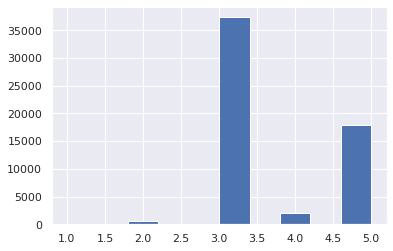

In [5]:
# 3 annotator + 5 if mismatching
_ = plt.hist(D.groupby('id').agg('count')['text'])

In [6]:
# aggregate by each reddit comments
D = D.groupby(['id', 'text']).agg(np.sum).reset_index()
D.iloc[:, 3:] = D.iloc[:, 3:].clip(0, 1)
D.head(3)

,id,text,example_very_unclear,admiration,amusement,anger,annoyance,approval,caring,confusion,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,eczazk6,Fast as [NAME] will carry me. Seriously uptown...,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,eczb07q,You blew it. They played you like a fiddle.,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,eczb4bm,TL;DR No more Superbowls for [NAME]. Get ready...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
emotions = set(D.columns[3:])
positive = {'admiration', 'amusement', 'approval', 
            'caring', 'desire', 'excitement', 'gratitude', 
            'joy', 'love', 'optimism', 'pride', 'relief'}
negative = {'anger','annoyance','disappointment',
            'disapproval','disgust','embarrassment',
            'fear','grief','nervousness','remorse','sadness'}
ambiguous = {"confusion", "curiosity", "realization", "surprise"}

print(f'Fine grain emotions: {len(emotions)}')
print(f'Number of data: {len(D)}')
print(f'Number of positive emotions: {len(positive)}') 
print(f'Number of negative emotions: {len(negative)}')
print(f'Number of ambiguous emotions: {len(ambiguous)}')
print(f'Standalone emotions: {emotions - positive - negative - ambiguous}')

Fine grain emotions: 28
Number of data: 58011
Number of positive emotions: 12
Number of negative emotions: 11
Number of ambiguous emotions: 4
Standalone emotions: {'neutral'}


In [8]:
df_emotion = pd.DataFrame()
df_emotion['emotion'] = list(emotions)
df_emotion['group'] = 'standalone'
df_emotion['group'].loc[df_emotion['emotion'].isin(positive)] = 'positive'
df_emotion['group'].loc[df_emotion['emotion'].isin(negative)] = 'negative'
df_emotion['group'].loc[df_emotion['emotion'].isin(ambiguous)] = 'ambiguous'
df_emotion.head(3)

,emotion,group
0,caring,positive
1,nervousness,negative
2,embarrassment,negative


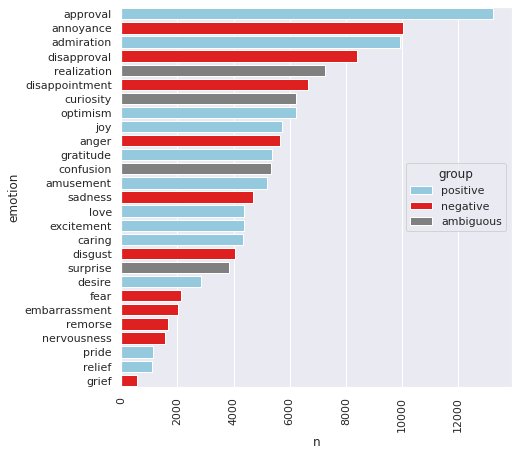

In [9]:
temp = D[emotions].sum(axis=0) \
    .reset_index() \
    .rename(columns={'index': 'emotion', 0: 'n'}) \
    .merge(df_emotion, how='left', on='emotion')\
    .sort_values('n', ascending=False)
temp = temp[temp['emotion'] != 'neutral']

fig, ax = plt.subplots(figsize=(7, 7))
ax.tick_params(axis='x', rotation=90)
palette ={
    "positive": "skyblue", 
    "negative": "red", 
    "ambiguous": 'gray'
}
sns.barplot(data=temp, x='n', 
            y='emotion', hue='group', 
            dodge=False,
            palette=palette,
            ax=ax)

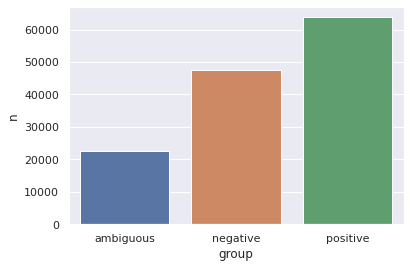

In [10]:
temp = temp.groupby('group') \
        .agg('sum').reset_index()

sns.barplot(data=temp, x='group', y='n')

In [11]:
df_emotion.columns

Index(['emotion', 'group'], dtype='object')

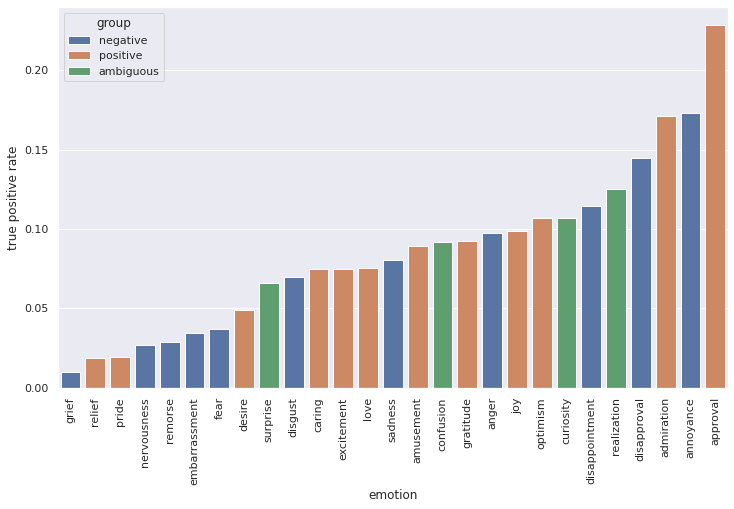

In [12]:
temp = pd.DataFrame()
temp['true positive rate'] = D.iloc[:, 3:-1].mean(0)
temp['emotion'] = D.columns[3:-1]
temp = temp.merge(df_emotion, how='left', on='emotion')
temp = temp.sort_values('true positive rate')

fig, ax = plt.subplots(figsize=(12, 7))
ax.tick_params(axis='x', rotation=90)

sns.barplot(x=temp['emotion'], 
            y=temp['true positive rate'], 
            hue=temp['group'], 
            dodge=False)

## Text

In [13]:
# cleaned dataset from main_prepare_dataset.ipynb
train_path = os.path.join(args.output_dir, args.train_dataset_path)
test_path = os.path.join(args.output_dir, args.test_dataset_path)
Dtr = pd.read_csv(train_path)
Dte = pd.read_csv(test_path)

Dcln = pd.concat([Dtr, Dte]).reset_index(drop=True)
Dcln.head(3)

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise
0,shit yeah. awesome fatality!!!,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"to bee fair, i those thing really mutual exclu...",0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,am juice traenforcedenforcedg about rise aware...,0,0,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


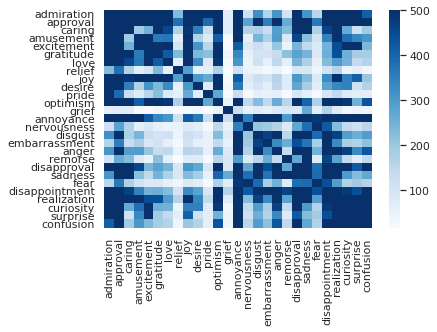

In [14]:
emt = [*positive, *negative, *ambiguous]
v = Dcln[emt]
df_cooc = v.T @ v
cooc = df_cooc.values
sns.heatmap(df_cooc.clip(upper=500), 
            xticklabels=True, yticklabels=True, 
            cmap='Blues')

In [15]:
E = np.empty((len(emt), len(emt) - 1), np.float)
for dim in range(len(emt)):
  vec = np.delete(cooc[dim], dim)
  vec = vec / (np.linalg.norm(vec) + 1e-16)
  E[dim, :] = vec
E.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


(27, 26)

In [16]:
def cosine_similarity(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

print('love, care', cosine_similarity(E[emt.index('love')], E[emt.index('caring')]))
print('love, disgust', cosine_similarity(E[emt.index('love')], E[emt.index('disgust')]))
print('disgust, annoyance', cosine_similarity(E[emt.index('disgust')], E[emt.index('annoyance')]))

love, care 0.8257897143366542
love, disgust 0.3674256863751681
disgust, annoyance 0.7970857855224256


In [17]:
sim = cosine_similarity(E, E.T)
# df_sim = pd.DataFrame(data=sim, columns=emt)
# df_sim.index = emt
sim.shape

(27, 27)

Text(0, 0.5, 'principal axis 2')

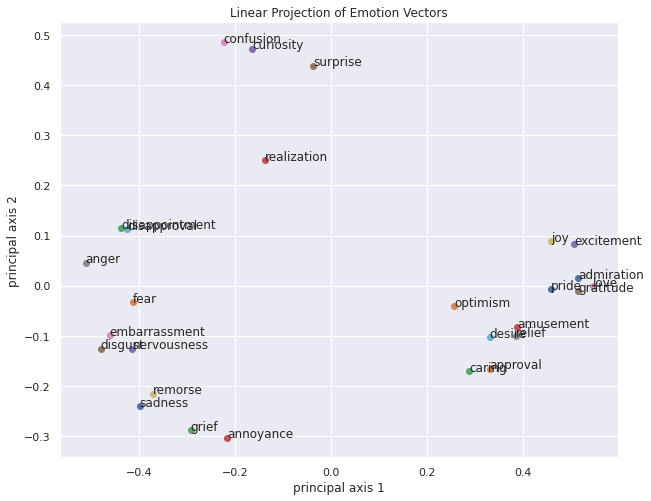

In [20]:
fig, ax = plt.subplots(figsize=(10, 8)) 

sim2 = PCA(2).fit_transform(E)
for i, e in enumerate(emt):
    group = df_emotion[df_emotion['emotion'] == e]['group'].item()
    ax.scatter(sim2[i, 0], sim2[i, 1], label=group)
    ax.annotate(e, (sim2[i, 0], sim2[i, 1]))

ax.set_title('Linear Projection of Emotion Vectors')
ax.set_xlabel('principal axis 1')
ax.set_ylabel('principal axis 2')